# ERA5 .nc colocated with TOPAZ to .npy

In [1]:
import os
import pandas as pd

from datetime import date

import xarray as xr
import numpy as np
from glob import glob
import datetime
import re

In [3]:
from src.data_preparation.running_mean import grid_center_running_mean as gcrm

In [4]:
import src.utils.load_config as load_config

login-1.fram.sigma2.no
fram detected


In [5]:
import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

login-1.fram.sigma2.no
fram detected


In [6]:
import yaml
user = yaml.load(open('../config/data_proc_demo.yaml'), Loader=yaml.FullLoader)['user']

In [7]:
file_config = '../config/data_proc_full.yaml'

nosit_dir, withsit_dir, _, forcing_bdir, pca_dir, res_dir, fig_dir, ml_dir = load_config.load_filename(file_config)
timeofday, target_field, forcing_fields, covar_fields, lim_idm, lim_jdm, n_comp = load_config.load_config_params(file_config)

PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated (pca_dir): ../config/data_proc_full.yaml
Config file updated: ../config/data_proc_full.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/xgb_Npred22_7F_rw21d_N4444_H1333_Hn0000_sithick_noname_220928-101057
Folder created

Config file updated.


In [8]:
datadir = os.path.join(rootdir,user+f'/forcings_full/ERA5_cTOPAZ/')

In [29]:

years=[2010, 2018]
allyears = np.arange(years[0], years[-1]+1)
# years=[1991,2020]


var = '2T'
# list_var = ['2T', 'MSL', '10V', '10U', 'TP', 'SSR', 'STR'] # , 'SKT']
# list_var = ['MSL', '10V', '10U', 'TP', 'SSR', 'STR', 'SKT']
list_var = [fo.split('_')[0] for fo in forcing_fields]

# new area for the new version of TOPAZ
# lim_jdm = (300, 629)
# lim_idm = (100, 550)


# In[9]:

# for var in list_var:

allfiles = sorted(glob(os.path.join(datadir,f'*{var}*.nc')))
var_idx = len(var)+1
listyear = [os.path.basename(name)[var_idx:var_idx+4] for name in allfiles]
listfile=[]

# selection corresponding years
for idx, name in enumerate(listyear):
    if int(name)>=years[0] and int(name)<=years[-1]:
        listfile += [allfiles[idx]]



In [10]:
nc = xr.open_mfdataset(listfile, combine='nested', concat_dim='time')

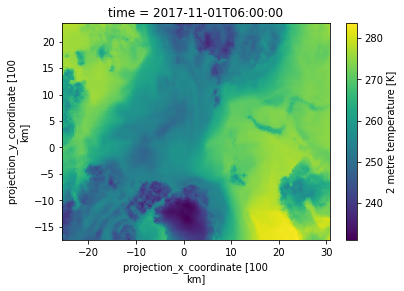

In [11]:
nc['2T'][11445].plot()

# Smoothing

In [12]:
# parameters

smooth = True
ndays = 15 # 29
nval_per_day = 4  # for ERA5


In [13]:
dttm = pd.to_datetime(nc['time'].to_numpy())  # get datetime for variable
raw_data = nc[f'{var}'].to_numpy()

In [14]:
if not smooth:
    print(f'Raw data at t = {timeofday}') 
    
    # determine index to keep based on timeofday
    idx_time = (dttm.time==datetime.time(int(timeofday * 24),0))
    
    forcing_data = raw_data[idx_time]
    
    savefile = os.path.join(rootdir, forcing_bdir, f'{var}.npy')
    np.save(savefile, forcing_data)
    print(f'Forcing saved as: {savefile}')

In [15]:
if smooth:
    print(f'Running windows of {ndays} days')    
    forcing_mean = np.empty((len(np.unique(dttm.date)), raw_data.shape[1], raw_data.shape[2]))
    
    print(f'Running mean over all gridpoints...')    
    smooth_data = gcrm(raw_data, ndays, npd=nval_per_day)
    
    savefile = os.path.join(rootdir, forcing_bdir, f'{var}_mean{ndays}d.npy')
    np.save(savefile, smooth_data)
    print(f'Forcing saved as: {savefile}')
#     del smooth_data 

Running windows of 15 days
Running mean over all gridpoints...
Forcing saved as: /nird/projects/nird/NS2993K/Leo/forcings_full/2T_mean15d.npy


-----

# Check smoothing in comparison to raw

In [16]:
import matplotlib.pyplot as plt

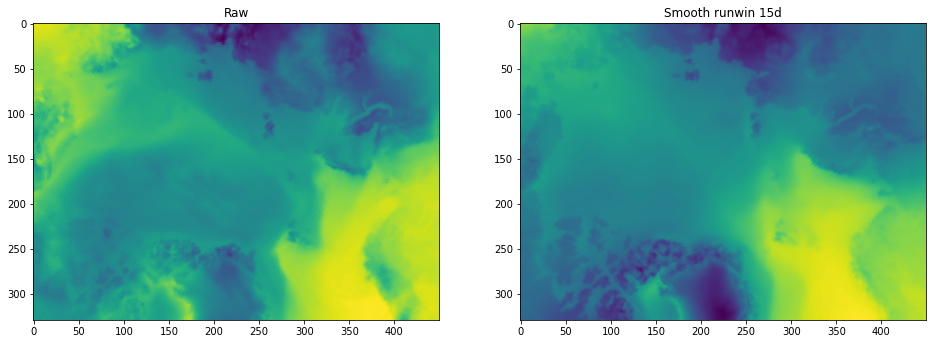

In [18]:
idx = 1500

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16, 9))

ax1.imshow(raw_data[idx][::-1])
ax1.set_title('Raw')

ax2.imshow(smooth_data[idx][::-1])
ax2.set_title(f'Smooth runwin {ndays}d');


-----

# load old forcing .npy to check format

In [22]:
field = 'airtmp'
olf_forcing_bdir = '/nird/projects/nird/NS2993K/Leo/forcings/'
old_f = np.load(os.path.join(rootdir, olf_forcing_bdir, f'{field}.npy'))

In [23]:
old_f.shape

(1461, 280, 400)

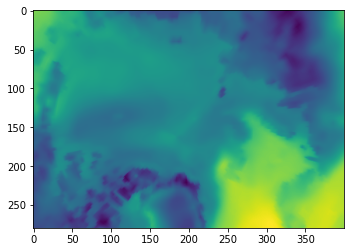

In [25]:
plt.imshow(old_f[0][::-1])